In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import math
import warnings # Tắt cảnh báo
warnings.filterwarnings('ignore')

In [12]:
# Trích xuất dữ liệu 
SSI=pd.read_csv('SSII.csv')
SSI['Date'] = pd.to_datetime(SSI['Date'])
SSI = SSI.set_index('Date')
SSI.head()


,Close
Date,
2006-12-18,11508
2006-12-19,12460
2006-12-20,12366
2006-12-21,11842
2006-12-22,10662


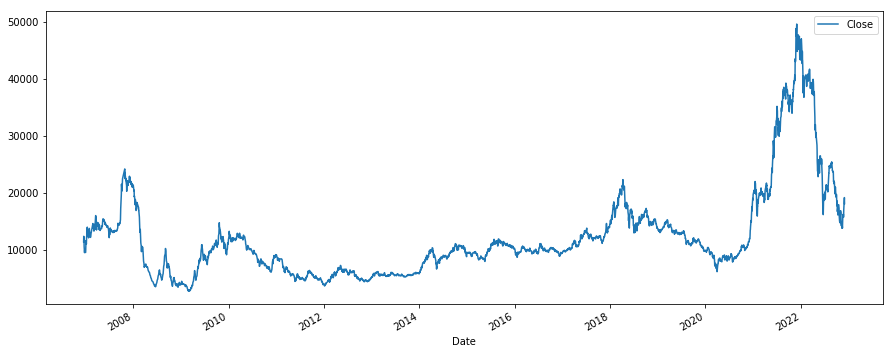

In [13]:
# Vẽ biểu đồ dữ liệu chuỗi thời gian
SSI.plot(figsize= (15,6))
plt.show()

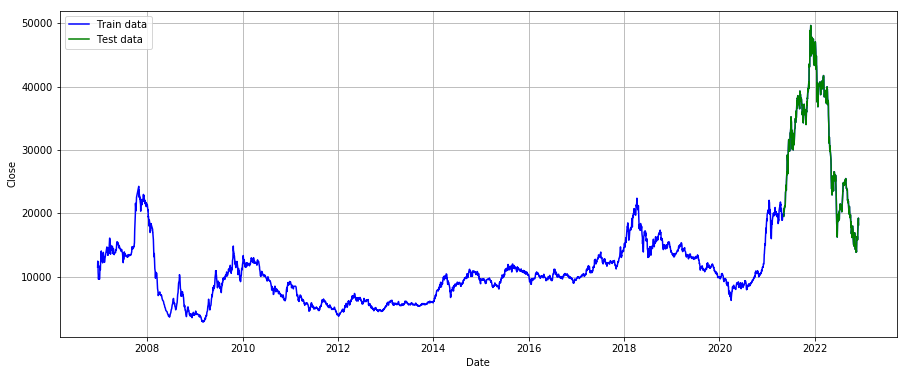

In [14]:
# Tách dữ liệu thành test và train
train_data, test_data = SSI[0:int(len(SSI)*0.9)], SSI[int(len(SSI)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(SSI, 'blue', label='Train data')
plt.plot(test_data, 'green', label='Test data')
plt.legend()

In [15]:
result=adfuller(train_data.dropna())
dict(zip(['adf', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'],result))

{'adf': -2.1194422058731455,
 'p-value': 0.23676899490382347,
 'usedlag': 14,
 'nobs': 3554,
 'critical values': {'1%': -3.432191313848521,
  '5%': -2.862353588774257,
  '10%': -2.567203086769004},
 'icbest': 49492.138718614995}

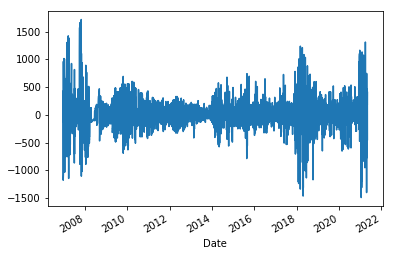

In [6]:
train_data['1difference']=train_data['Close']-train_data['Close'].shift(1)
 
train_data['1difference'].plot()

In [9]:
result=adfuller(train_data['1difference'].dropna())
dict(zip([' Test ADF', 'p-value', 'No. of lags used ', 'Number of observations used ', 'critical values', 'icbest'],result))



{' Test ADF': -14.584973975862507,
 'p-value': 4.406828534679589e-27,
 'No. of lags used ': 13,
 'Number of observations used ': 3554,
 'critical values': {'1%': -3.432191313848521,
  '5%': -2.862353588774257,
  '10%': -2.567203086769004},
 'icbest': 49482.033578866445}

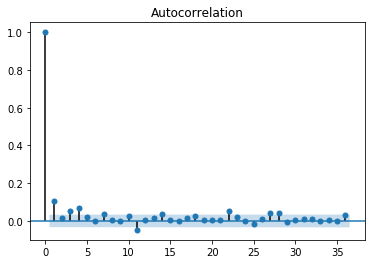

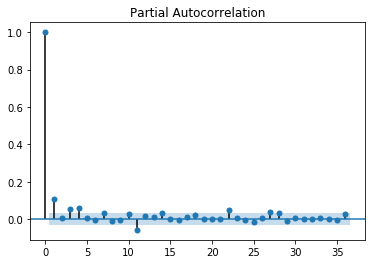

In [11]:
fig1=plot_acf(train_data['1difference'].dropna()) 
fig2=plot_pacf(train_data['1difference'].dropna())

In [15]:
def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models
# p=q=1,3,4,7,11,14,22
orders=[(0,1,1),(1,1,0),(1,1,1),(4,1,0),(0,1,4),(4,1,22)]
models = _arima_fit(orders, train_data)


ARIMA(0,1,1) --> AIC=50067.27208474071; BIC=50085.81136622181
ARIMA(1,1,0) --> AIC=50066.86749697551; BIC=50085.40677845661
ARIMA(1,1,1) --> AIC=50063.79307764524; BIC=50088.51211962004
ARIMA(4,1,0) --> AIC=50052.0002330938; BIC=50089.078796056
ARIMA(0,1,4) --> AIC=50054.476445895925; BIC=50091.55500885812
ARIMA(4,1,22) --> AIC=50048.206674239686; BIC=50221.23996806328


In [11]:
model = ARIMA(train_data, order=(4, 1, 22)) 
fitted = model.fit(method='css-mle')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3568
Model:                ARIMA(4, 1, 22)   Log Likelihood              -24996.103
Method:                       css-mle   S.D. of innovations            266.841
Date:                Mon, 06 Mar 2023   AIC                          50048.207
Time:                        20:50:25   BIC                          50221.240
Sample:                             1   HQIC                         50109.900
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.7436      7.102      0.386      0.699     -11.176      16.663
ar.L1.D.Close      0.5447      0.723      0.753      0.451      -0.873       1.962
ar.L2.D.Close     -0.2022      1.019

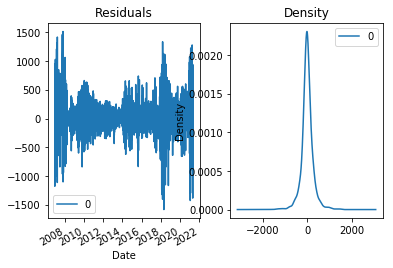

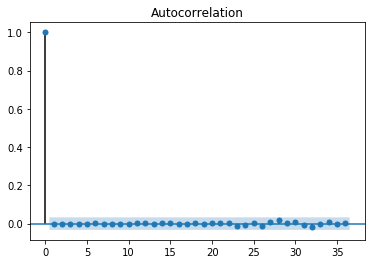

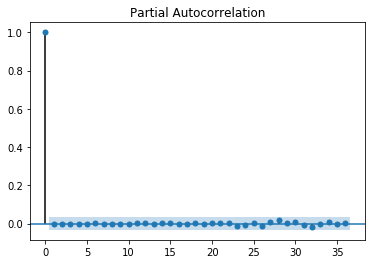

{'adf': -59.75693131063201,
 'p-value': 0.0,
 'usedlag': 0,
 'nobs': 3567,
 'critical values': {'1%': -3.432184598306239,
  '5%': -2.8623506224106547,
  '10%': -2.5672015075684036},
 'icbest': 49436.653969355946}

In [12]:
# Plotting Residual Errors 

residuals = pd.DataFrame(fitted.resid)  
fig, ax = plt.subplots(1,2) 
residuals.plot(title = "Residuals", ax = ax[0])  
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1]) 
fig1=plot_acf(residuals.dropna()) 
fig2=plot_pacf(residuals.dropna())
plt.show()  

result1=adfuller(residuals.dropna())
dict(zip(['adf', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'],result1))


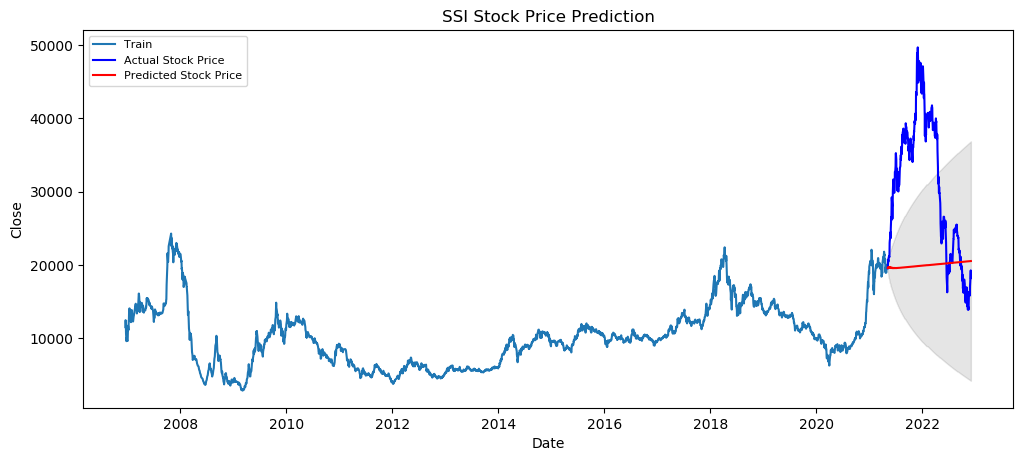

In [13]:
# Dự báo
fc, se, conf = fitted.forecast(397, alpha=0.05)  # 95% độ tin cậy
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SSI Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
print('MSE:')
print(mean_squared_error(test_data, fc))
print('RMSE:')
print(np.sqrt(mean_squared_error(test_data, fc)))
print('MAE:')
print(mean_absolute_error(test_data, fc)) 
print('MAPE:')
print(mean_absolute_percentage_error(test_data, fc))

MSE:
207533035.83852234
RMSE:
14406.006935945934
MAE:
11744.363260715643
MAPE:
0.33522157551171566
